# (WIP) 08. PyTorch Paper Replicating

Want to recreate ViT paper: "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" - https://arxiv.org/abs/2010.11929 - TK will refer to this as "ViT paper" throughout.

* TK - What is paper replicating?
* TK - What is a machine learning research paper?
* TK - Where can you find code examples for machine learning research papers?
    * Paperswithcode
* TK - Why replicate a machine learning research paper?
    * TK - quote from George Hotz 
    
* TK - Keep in mind: research papers are often *months* of work by some of the best machine learning teams in the world condensed into a few pages of text. So it makes sense if it takes some practice to replicate them.

## TK - What we're going to cover

TODO

## TK - Where can you get help?

All of the materials for this course [are available on GitHub](https://github.com/mrdbourke/pytorch-deep-learning).

If you run into trouble, you can ask a question on the course [GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

And of course, there's the [PyTorch documentation](https://pytorch.org/docs/stable/index.html) and [PyTorch developer forums](https://discuss.pytorch.org/), a very helpful place for all things PyTorch. 

## TK 0. Getting setup 

As we've done previously, let's make sure we've got all of the modules we'll need for this section.

We'll import the Python scripts (such as `data_setup.py` and `engine.py`) we created in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).

To do so, we'll download [`going_modular`](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular) directory from the `pytorch-deep-learning` repository (if we don't already have it).

We'll also get the [`torchinfo`](https://github.com/TylerYep/torchinfo) package if it's not available. 

`torchinfo` will help later on to give us a visual representation of our model.

And since later on we'll be using a newer version of the `torchvision` package (as of June 2022), we'll make sure we've got the latest versions.

In [6]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.0.dev20220606
torchvision version: 0.14.0.dev20220606


> **Note:** If you're using Google Colab, you may have to restart your runtime after running the above cell. After restarting, you can run the cell again and verify you've got the right versions of `torch` and `torchvision`.

Now we'll continue with the regular imports, device agnostic code and helper functions.

In [7]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

> **Note:** If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via `Runtime -> Change runtime type -> Hardware accelerator -> GPU`.

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

And let's download the [`helper_functions.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py) script (if it doesn't already) exist to import functions we've created in previous notebooks, namely: 
* `set_seeds()` to set the random seeds (created in 07. PyTorch Experiment Tracking).
* `download_data()` to download a data source given a link (created in 07. PyTorch Experiment Tracking).
* `plot_loss_curves()` to inspect our model's training results (created in [04. PyTorch Custom Datasets section 7.8](https://www.learnpytorch.io/04_pytorch_custom_datasets/#78-plot-the-loss-curves-of-model-0))
* TK - links for above scripts
* Note: The `helper_functions.py` script could technically be merged into `going_modular/going_modular/utils.py` if we wanted it to, perhaps that's an extension you'd like to try.



In [13]:
# Get various functions from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves, set_seeds, download_data
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves, set_seeds, download_data

## TK 1. Get Data

* TK - you could use other vision datasets here, e.g. from `torchvision.datasets` but for consistency, we're staying with pizza, steak, sushi. 

In [14]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

## TK 2. Create Datasets and DataLoaders

TK - Info here about training from scratch etc...

* TK - **Note:** Using `pin_memory=True` in `create_dataloaders()` to speed things up (prevents too many copies from CPU to GPU memory). 

In [161]:
# Setup hyerparameters
BATCH_SIZE = 128 # TK - ViT paper uses higher batch size but set this too high your hardware might not be able to cope
IMG_SIZE = 224

# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Create transform pipeline manually

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


(<torch.utils.data.dataloader.DataLoader at 0x7f95615d56f0>,
 ['pizza', 'steak', 'sushi'])

### TK 2.1 Visualize an image

Let's get visual.

TK An important step in the ViT paper is preparing the images into patches.

In [163]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
# TK - print batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

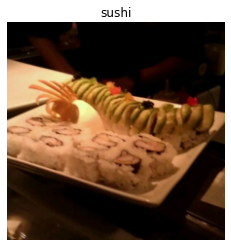

In [164]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## TK 3. Replicating ViT: Overview

Idea for replicating: 

* Turn the paper into blocks of code
* Replicate one small block at a time 
* Think of a block as either: a *single* layer or a *collection* of layers
    * For understanding: focus on the inputs & outputs of each block to see how they fit together
        * Recall a layer takes some data in (input), modifies it in some way (with a `forward()` method) and then returns it (output) 
    * Since we'll be using pre-built PyTorch layers (recommended), to learn more about each layer, research the documentation or other relative resources
* Combine the blocks at the end

TK - sections of the paper to pay attention to:
* My workflow: Read the whole thing once, go back through each section and turn it into code
* If I get stuck, look up other examples
* Repeat
* Use mathpix.com to turn sections into markdown (for reproducing the paper in notebooks)

Model:
* TK - We are making ViT-Base from Table 1 (though we'll write code so you could adjust it if you wanted to make the other models, however, these models are much larger and will require adequate hardware to run -> start small, increase when necessary).
* TK image - table 1 from the ViT paper -> the different hyperparameters of each model

## TK 4. Split data into patches

Want to visualize the data and see if it can be split into patches with a Conv2D layer.

See Figure 1 - the image gets embedded into patches, that's what I want to create

Also section 3.1:

> To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer.
> 
> "All models use an image size of 224"

To handle 2D images, we reshape the image `x` (HxWxC) -> `x` (Nx(P^2•C)) where:
* (H, W) is the resolution of the original image
* C is the number of channels
* (P, P) is the resolution of each patch
* N = HW/P^2

Patch size from paper: "ViT-B/16 means the “Large” variant with 16×16 input patch size"

Let's say I want patches of 16x16, I want a Conv2d with:
* in_channels=3 (number of channels)
* out_channels=D (number of hidden units)
* kernel=patch_size (make the kernel the patch)
* padding="same" (want to keep the same dimensions of the input as the output)
* stride=patch_size (stride the size of the patch)

In [165]:
# Example of calculating N
PATCH_SIZE = 16
IMG_SIZE = 224
height, width = IMG_SIZE, IMG_SIZE
N = (height * width) / PATCH_SIZE ** 2
N

196.0

In [166]:
# Example of calculating output shape
16**2 * 3

768

In [167]:
from torch import nn
patch_size=16

# Create the embedding and the patch in one hit 
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768, # from Table 1: Hidden size D
                   kernel_size=PATCH_SIZE,
                   stride=PATCH_SIZE,
                   padding=0)

flatten = nn.Flatten(start_dim=2, 
                     end_dim=3) # https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html 

In [168]:
# Now we have a patchified image of 256 tokens + an embedding for each patch
patch_image_out_of_conv = conv2d(image.unsqueeze(0))
print(patch_image_out_of_conv.shape)
patch_image = flatten(conv2d(image.unsqueeze(0)))
patch_image.shape

torch.Size([1, 768, 14, 14])


torch.Size([1, 768, 196])

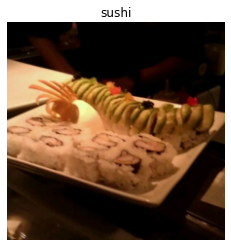

In [169]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

Showing 10 random Conv2d patches from index 644 to 654


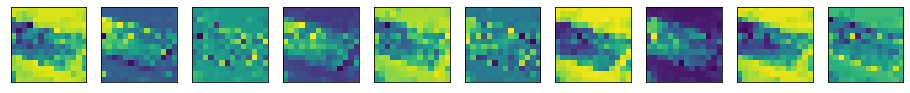

In [170]:
# Plot random 10 conv patches
import random
random_start = random.randint(0, 758)
random_end = random_start + 10
print(f"Showing 10 random Conv2d patches from index {random_start} to {random_end}")
patches = patch_image_out_of_conv[:, random_start:random_start+10, :, :]

fig, axs = plt.subplots(ncols=10, squeeze=False, figsize=(16, 16))
for i in range(10):
    axs[0, i].imshow(patches[:, i, :, :].squeeze().detach().numpy())
    axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [171]:
# Get image in shape [batch_size, N, P^2*C]
patch_image.transpose(-2, -1).shape

torch.Size([1, 196, 768])

In [172]:
# Get image in shape [batch_size, N, P^2*C]
reshaped_patch_image = patch_image.permute(0, 2, 1)
reshaped_patch_image.shape

torch.Size([1, 196, 768])

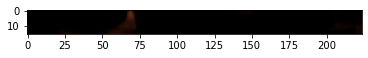

In [173]:
# Color channels, height, width
# Want the top row
plt.imshow(image[:, :patch_size, :].permute(1, 2, 0));

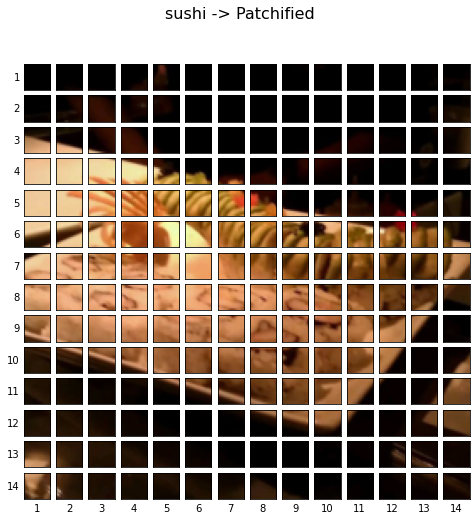

In [174]:
PATCH_SIZE = 16
IMG_SIZE = 224
assert image.shape[1] % PATCH_SIZE == 0, "Image size must be divisble by patch size." 

# Create a series of subplots
fig, axs = plt.subplots(nrows=IMG_SIZE // PATCH_SIZE, # need int not float
                        ncols=IMG_SIZE // PATCH_SIZE, 
                        figsize=(PATCH_SIZE // 2, PATCH_SIZE // 2),
                        sharex=True,
                        sharey=True)

# Go from (C, H, W) -> (H, W, C) for matplotlib 
image_permuted = image.permute(1, 2, 0)
for i, patch_h in enumerate(range(0, IMG_SIZE, PATCH_SIZE)):
    for j, patch_w in enumerate(range(0, IMG_SIZE, PATCH_SIZE)):
        # Plot coordinates = (i, j)
        # print(f"On patch: {i+1}, {j+1}")
        
        # Plot the permuted image (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_h:patch_h+PATCH_SIZE, # iterate through height 
                                        patch_w:patch_w+PATCH_SIZE, # iterate through width
                                        :]) # get all color channels
        
        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### 4.1 Create patching layer

UPTOHERE: rewriting all of the code for each block from scratch

In [175]:
class Patching(nn.Module):
    def __init__(self,
                 in_channels=3,
                 patch_size=16,
                 embedding_dim=768): # from paper table 1
        super().__init__()
        
        self.patcher = nn.Sequential(
            nn.Conv2d(in_channels, 
                      embedding_dim,
                      kernel_size=patch_size,
                      stride=patch_size),
            nn.Flatten(2, 3))

    def forward(self, x):
        # return self.patcher(x)
        return self.patcher(x).permute(0, 2, 1) # [batch_size, P^2*C, N] -> [batch_size, N, P^2*C] 
    
patcher = Patching(in_channels=3,
                   patch_size=16,
                   embedding_dim=768)

patched_image = patcher(image.unsqueeze(0))
patched_image.shape

torch.Size([1, 196, 768])

In [176]:
patched_image

tensor([[[ 0.0068,  0.0264,  0.0086,  ..., -0.0031,  0.0047, -0.0106],
         [ 0.0070,  0.0230,  0.0119,  ...,  0.0014,  0.0085, -0.0105],
         [ 0.0055,  0.0266,  0.0069,  ..., -0.0024,  0.0070, -0.0131],
         ...,
         [ 0.0176,  0.0238,  0.0138,  ...,  0.0060,  0.0058, -0.0284],
         [ 0.0404,  0.0470,  0.0264,  ...,  0.0306, -0.0123, -0.0604],
         [ 0.1118,  0.0026,  0.0629,  ...,  0.0202,  0.0229, -0.0191]]],
       grad_fn=<PermuteBackward0>)

## TK 5. Create feedforward model (MLP)

> Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings. 

> The MLP contains two layers with a GELU non-linearity

$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L
\end{aligned}
$$ 

In [177]:
class FeedForward(nn.Module):
    """Creates feed foward layer of MLP"""
    def __init__(self,
                 in_features,
                 out_features,
                 dropout=0):
        super().__init__()
        
        self.feedforward = nn.Sequential(
            nn.Linear(in_features=in_features,
                      out_features=out_features),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=out_features,
                      out_features=in_features),
            nn.Dropout(p=dropout))
        
    def forward(self, x):
        return self.feedforward(x)

## TK. 6. Create MSA (Multihead Self-Attention)

See docs - https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html

Heads = 12 

In [178]:
class MSABlock(nn.Module):
    """Creates a multi-head self-attention block: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html"""
    def __init__(self,
                 embed_dim,
                 num_heads=12,
                 attn_dropout=0):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, 
                                                    num_heads, 
                                                    dropout=0,
                                                    batch_first=True) # (batch, seq, feature)
        
    def forward(self, x):
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [179]:
patched_image.shape

torch.Size([1, 196, 768])

In [180]:
msa_block = MSABlock(embed_dim=768, num_heads=12)
msa_block(patched_image).shape

torch.Size([1, 196, 768])

## TK 7. Create transformer block


In [181]:
class TransformerBlock(nn.Module):
    """Creates a transformer block as a combination of Norm, MSA and MLPs."""
    def __init__(self,
                 embed_dim=768,
                 num_heads=12,
                 feedforward_dropout=0.1,
                 attn_dropout=0, 
                 feedforward_hidden=3072):
        super().__init__()
        
        # Create attention norm
        self.attn_norm = nn.LayerNorm(embed_dim)
        
        # Create feedforward norm
        self.feedforward_norm = nn.LayerNorm(embed_dim)
        
        # Create attention block
        self.attn_block = nn.Sequential(
            self.attn_norm,
            MSABlock(embed_dim,
                     num_heads,
                     attn_dropout))
        
        # Create feedforward block
        self.feedforward_block = nn.Sequential(
            self.feedforward_norm,
            FeedForward(embed_dim,
                        feedforward_hidden,
                        feedforward_dropout))
    
    def forward(self, x):
        x = self.attn_block(x) + x # add in skip connections
        x = self.feedforward_block(x) + x 
        return x     

## TK 8. Putting it all together to create ViT

Combine the transformer blocks and patched embedding into a ViT architecture.

In [182]:
class ViT(nn.Module):
    def __init__(self,
                 img_size=224,
                 in_channels=3,
                 patch_size=16,
                 embed_dim=768,
                 embed_dropout=0.1,
                 num_blocks=12,
                 num_heads=12,
                 feedforward_dropout=0.1,
                 attn_dropout=0,
                 feedforward_hidden=3072,
                 num_classes=10):
        super().__init__()
        
        # TK - make assertion about patch size and image size
        
        # Get image size
        self.image_height, self.image_width = img_size, img_size
        
        # Create embedding dropout
        self.embed_dropout = nn.Dropout(p=embed_dropout)
        
        # Calculate number of patches
        self.num_patches = (self.image_height * self.image_width) // patch_size**2
        
        # Create pos embedding (from index 1 -> last of patch embedding size)
        self.position_embedding = nn.Parameter(data=torch.randn(1, 
                                                                self.num_patches+1, 
                                                                embed_dim),
                                               requires_grad=True)
                 
        # Create class embed (needs to go at front of sequence embedding)
        self.class_embedding = nn.Parameter(torch.randn(1, 1, embed_dim),
                                            requires_grad=True)
        
        # Create patching layer
        self.patcher = Patching(in_channels=in_channels,
                                patch_size=16,
                                embedding_dim=embed_dim)
        
        # Create transformer blocks
        self.transformer_blocks = nn.Sequential(*[TransformerBlock(embed_dim=embed_dim,
                                                                   num_heads=num_heads,
                                                                   feedforward_dropout=feedforward_dropout,
                                                                   attn_dropout=attn_dropout,
                                                                   feedforward_hidden=feedforward_hidden) for _ in range(num_blocks)])
        
        # Create classifier head 
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        
    def forward(self, x):
        # Create patches of input
        x = self.patcher(x)

        # Expand class_embeddings to be all of the batch size
        batch_size = x.shape[0] # get batch size
        class_tokens = self.class_embedding.expand(batch_size, -1, -1) # want one class_embedding per sample in the batch 

        # Add class embedding to front of patch embeddings
        x = torch.cat((class_tokens, x), dim=1)

        # Add positional embedding 
        x = x + self.position_embedding

        # Perform embedding dropout
        x = self.embed_dropout(x)
        
        # Put x through Transformer blocks
        x = self.transformer_blocks(x)

        # Put x through classifier layer (only the class token)
        x = self.classifier(x[:, 0])

        return x

In [183]:
set_seeds()
device = "cuda" if torch.cuda.is_available() else "cpu"
rand_image = torch.randn(1, 3, 224, 224)
vit = ViT(num_classes=len(class_names)) 
vit(rand_image)

tensor([[0.6395, 1.0399, 0.1285]], grad_fn=<AddmmBackward0>)

## TK 9. Inspect the model

> **Note:** If you go too big, your hardware might not be able to handle it... (e.g. too high of a batch size...)

In [184]:
from torchinfo import summary

# TK - clean up the summary so it looks nice when it prints out 
# Print a summary using torchinfo (uncomment for actual output)
summary(model=vit, 
        input_size=(128, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                     Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                                   [128, 3, 224, 224]   [128, 3]             152,064              True
├─Dropout (embed_dropout)                                                   [128, 197, 768]      [128, 197, 768]      --                   --
├─Patching (patcher)                                                        [128, 3, 224, 224]   [128, 196, 768]      --                   True
│    └─Sequential (patcher)                                                 [128, 3, 224, 224]   [128, 768, 196]      --                   True
│    │    └─Conv2d (0)                                                      [128, 3, 224, 224]   [128, 768, 14, 14]   590,592              True
│    │    └─Flatten (1)                                                     [128, 768, 14, 14]   [128, 768, 196]      --             

* TK - same number of parameters as: https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16 -> 86567656

In [185]:
batch_size = 32
cls_embedding = nn.Parameter(torch.randn(1, 1, 768))
# See here: https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html
cls_embedding.shape, cls_embedding.expand(batch_size, -1, -1).shape

(torch.Size([1, 1, 768]), torch.Size([32, 1, 768]))

## TK 10. Train model



In [188]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=1e-3,
                             betas=(0.9, 0.999), # default
                             weight_decay=0.1) # from the ViT paper section 4.1
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=25,
                       device=device)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.6047 | train_acc: 0.4453 | test_loss: 1.7205 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.2773 | train_acc: 0.2734 | test_loss: 2.2151 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2613 | train_acc: 0.4844 | test_loss: 1.6389 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.3539 | train_acc: 0.3008 | test_loss: 1.3472 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1651 | train_acc: 0.2969 | test_loss: 1.3505 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1574 | train_acc: 0.2773 | test_loss: 1.6847 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1599 | train_acc: 0.4023 | test_loss: 1.8797 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1868 | train_acc: 0.4336 | test_loss: 1.4380 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1435 | train_acc: 0.4180 | test_loss: 1.0768 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2625 | train_acc: 0.2539 | test_loss: 1.0315 | test_acc: 0.5417
Epoch: 11 | train_loss: 1.1373 | train_acc: 0.3164 | test_loss: 1.3577 | test_acc: 0.2604
Epoch: 12 | train_l

## TK 11. Evaluate model

TK - plot the loss curves

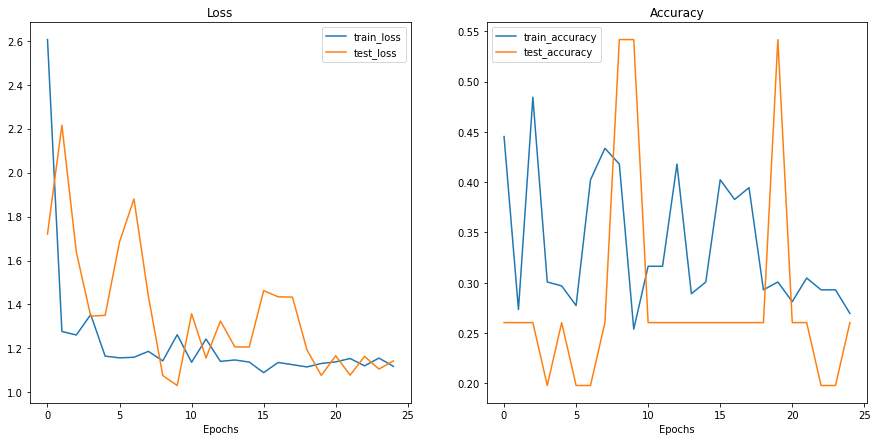

In [189]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

TK - why do the loss curves look the way they do? (too big of a model, not enough data)

## TK 12. Bring in pretrained ViT from `torchvision.models` on same dataset 

* Get a similar model from here - https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16 

In [42]:
import torch
import torchvision

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [44]:
# Set seeds
def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [45]:
# Requires torchvision >= 0.13
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# Change the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [46]:
# Create dataset for pretrained ViT
import torch
import torchvision
import matplotlib.pyplot as plt 

# # Make transform, let's get bigger images
# img_size = 224
# transform = torchvision.transforms.Compose([
#     torchvision.transforms.Resize((img_size, img_size)),
#     torchvision.transforms.ToTensor()
# ])

# Requires torchvision >= 0.13
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_transforms = weights.transforms()

# Start with CIFAR10
train_data = torchvision.datasets.CIFAR10(root="data",
                                          train=True,
                                          transform=vit_transforms,
                                          download=True)

test_data = torchvision.datasets.CIFAR10(root="data",
                                         train=False,
                                         transform=vit_transforms,
                                         download=True)

# Get class names
class_names = train_data.classes
print(f"Class names: {class_names}")

# Create dataloaders
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               pin_memory=True,
                                               num_workers=2) 

test_dataloader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=2)

len(train_dataloader), len(test_dataloader)

Files already downloaded and verified
Files already downloaded and verified
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


(391, 79)

In [47]:
# Train feature extractor ViT for 5 epochs on CIFAR10
# TK - can probably increase the batch_size here because we're using feature extraction and not 
# training the whole model
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
results = engine.train(model=pretrained_vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2860 | train_acc: 0.9218 | test_loss: 0.1840 | test_acc: 0.9413
Epoch: 2 | train_loss: 0.1579 | train_acc: 0.9480 | test_loss: 0.1665 | test_acc: 0.9458
Epoch: 3 | train_loss: 0.1386 | train_acc: 0.9554 | test_loss: 0.1578 | test_acc: 0.9486
Epoch: 4 | train_loss: 0.1270 | train_acc: 0.9585 | test_loss: 0.1537 | test_acc: 0.9500
Epoch: 5 | train_loss: 0.1189 | train_acc: 0.9610 | test_loss: 0.1522 | test_acc: 0.9498


In [ ]:
# # Feature extractor results before pin_memory=True and num_workers=2
# 100%
# 5/5 [21:34<00:00, 259.41s/it]
# Epoch: 1 | train_loss: 0.2860 | train_acc: 0.9202 | test_loss: 0.1841 | test_acc: 0.9430
# Epoch: 2 | train_loss: 0.1584 | train_acc: 0.9486 | test_loss: 0.1658 | test_acc: 0.9455
# Epoch: 3 | train_loss: 0.1381 | train_acc: 0.9551 | test_loss: 0.1584 | test_acc: 0.9479
# Epoch: 4 | train_loss: 0.1271 | train_acc: 0.9582 | test_loss: 0.1532 | test_acc: 0.9487
# Epoch: 5 | train_loss: 0.1193 | train_acc: 0.9606 | test_loss: 0.1525 | test_acc: 0.9498

# # Results after pin_memory=True and num_workers=2
# 100%
# 5/5 [17:57<00:00, 215.69s/it]
# Epoch: 1 | train_loss: 0.2860 | train_acc: 0.9218 | test_loss: 0.1840 | test_acc: 0.9413
# Epoch: 2 | train_loss: 0.1579 | train_acc: 0.9480 | test_loss: 0.1665 | test_acc: 0.9458
# Epoch: 3 | train_loss: 0.1386 | train_acc: 0.9554 | test_loss: 0.1578 | test_acc: 0.9486
# Epoch: 4 | train_loss: 0.1270 | train_acc: 0.9585 | test_loss: 0.1537 | test_acc: 0.9500
# Epoch: 5 | train_loss: 0.1189 | train_acc: 0.9610 | test_loss: 0.1522 | test_acc: 0.9498

## TK - Exercises

## TK - Extra-curriculum

* See the illustrated transformer for an overview of the Transformer model:  https://jalammar.github.io/illustrated-transformer/